## Healthcare Insurance Cost Prediction - Linear Regression Analysis

## Mission Statement
Develop a predictive model for healthcare insurance costs to help individuals estimate their medical expenses and make informed financial decisions.

## Dataset Information
- **Source:** Kaggle - Medical Cost Personal Dataset
- **Size:** 1,338 records with 6 features
- **Features:** age, sex, bmi, children, smoker, region
- **Target:** charges (individual medical costs billed by health insurance)

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

## 1. Data Loading and Initial Exploration

In [3]:
# Load the dataset
data = pd.read_csv('insurance.csv')

# Display basic information
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
data.head()

Dataset Shape: (1338, 7)

First 5 rows:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Check for missing values and data types
print("Data Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nBasic Statistics:")
data.describe()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Missing Values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Basic Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## 2. Data Visualization and Interpretation

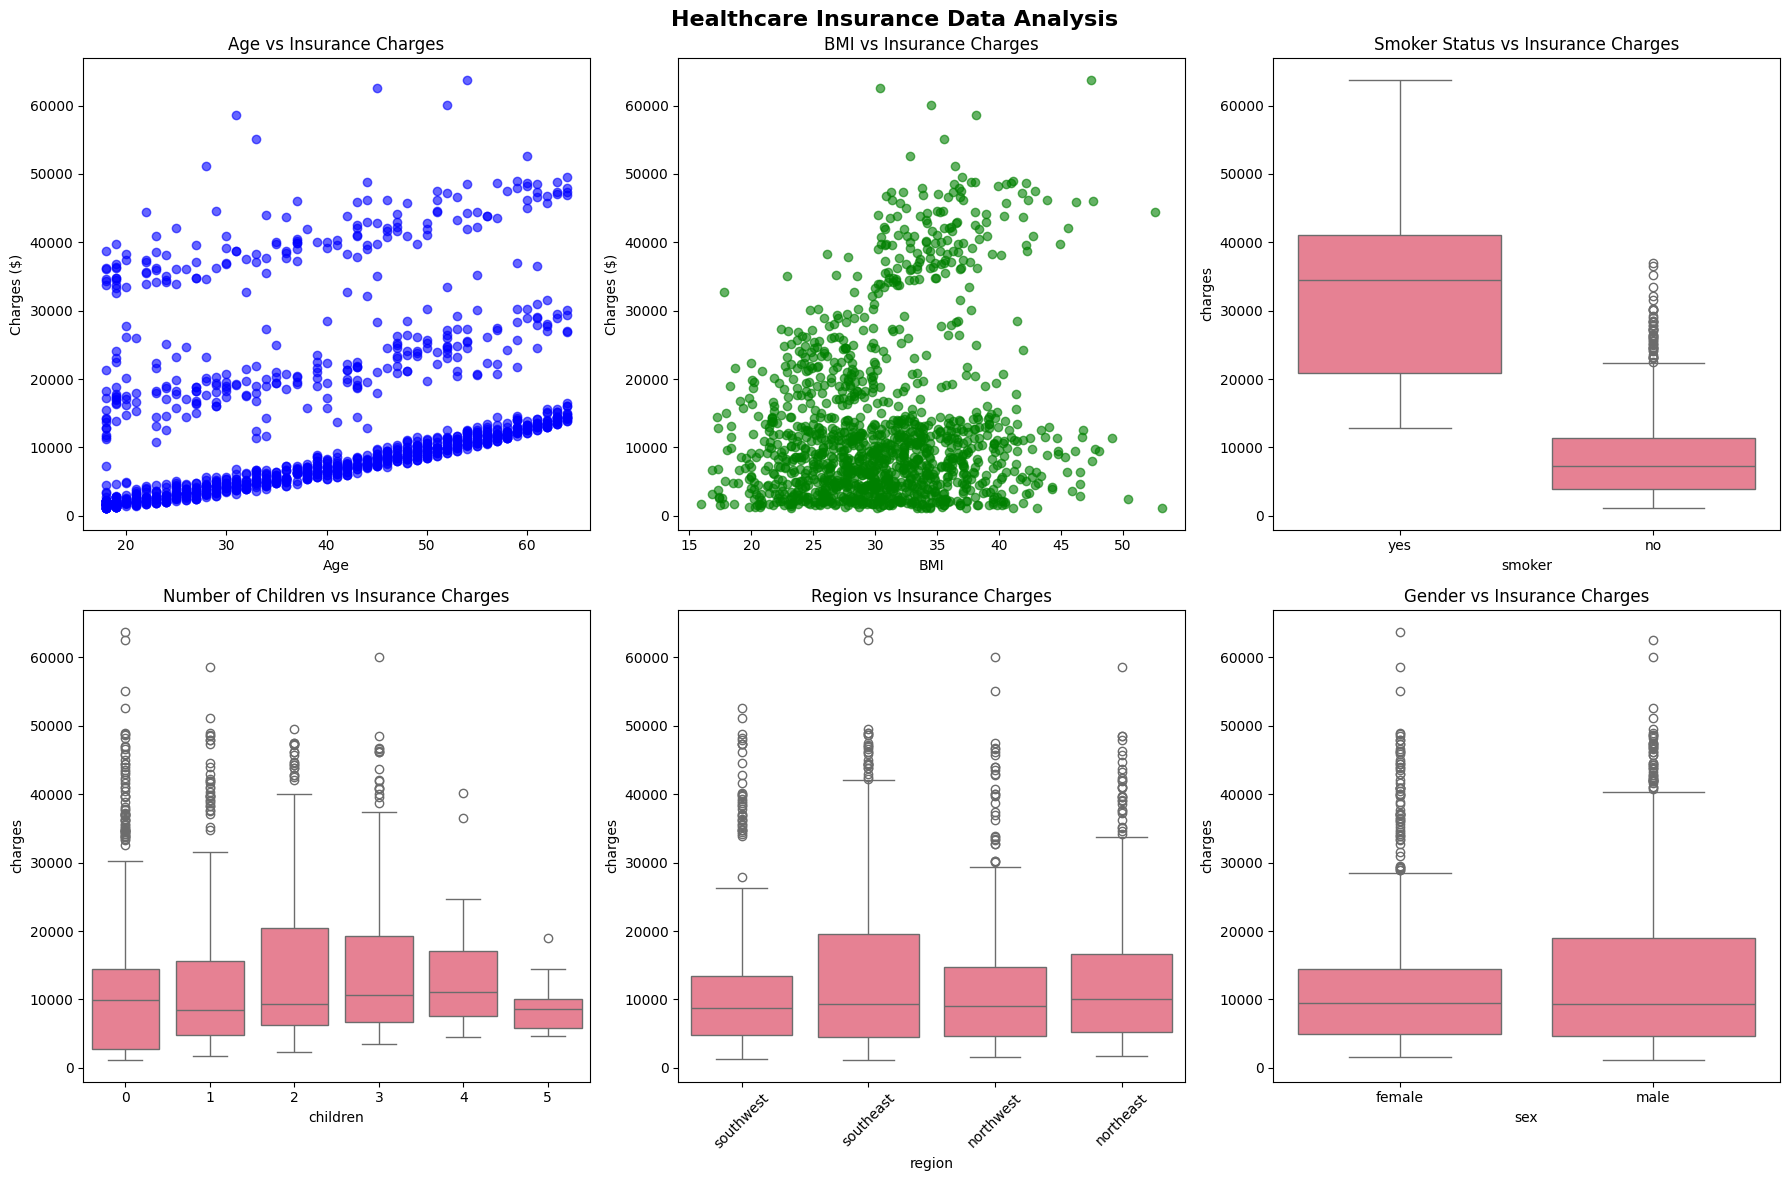

In [5]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Healthcare Insurance Data Analysis', fontsize=16, fontweight='bold')

# Age vs Charges
axes[0,0].scatter(data['age'], data['charges'], alpha=0.6, color='blue')
axes[0,0].set_title('Age vs Insurance Charges')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Charges ($)')

# BMI vs Charges
axes[0,1].scatter(data['bmi'], data['charges'], alpha=0.6, color='green')
axes[0,1].set_title('BMI vs Insurance Charges')
axes[0,1].set_xlabel('BMI')
axes[0,1].set_ylabel('Charges ($)')

# Smoker vs Charges
sns.boxplot(data=data, x='smoker', y='charges', ax=axes[0,2])
axes[0,2].set_title('Smoker Status vs Insurance Charges')

# Children vs Charges
sns.boxplot(data=data, x='children', y='charges', ax=axes[1,0])
axes[1,0].set_title('Number of Children vs Insurance Charges')

# Region vs Charges
sns.boxplot(data=data, x='region', y='charges', ax=axes[1,1])
axes[1,1].set_title('Region vs Insurance Charges')
axes[1,1].tick_params(axis='x', rotation=45)

# Sex vs Charges
sns.boxplot(data=data, x='sex', y='charges', ax=axes[1,2])
axes[1,2].set_title('Gender vs Insurance Charges')

plt.tight_layout()
plt.show()

## 3. Feature Engineering and Data Preprocessing

In [6]:
# Feature Engineering Analysis
print("FEATURE ENGINEERING DECISIONS:")
print("=" * 50)

# Analyze correlation with target variable
numeric_cols = ['age', 'bmi', 'children']
for col in numeric_cols:
    correlation = data[col].corr(data['charges'])
    print(f"{col.upper()}: Correlation with charges = {correlation:.3f}")

# Analyze categorical variables impact
print("\nCATEGORICAL VARIABLES IMPACT:")
print(f"Smoker - Average charges: Yes=${data[data['smoker']=='yes']['charges'].mean():.0f}, No=${data[data['smoker']=='no']['charges'].mean():.0f}")
print(f"Gender - Average charges: Male=${data[data['sex']=='male']['charges'].mean():.0f}, Female=${data[data['sex']=='female']['charges'].mean():.0f}")

print("\nFEATURE DECISIONS:")
print("KEEP ALL FEATURES - All show meaningful relationships with insurance charges")
print("AGE: Strong positive correlation (older = higher costs)")
print("BMI: Moderate correlation (higher BMI = higher costs)")
print("SMOKER: Strongest predictor (smokers pay ~4x more)")
print("CHILDREN: Slight positive correlation")
print("SEX & REGION: Moderate impact, worth keeping")

FEATURE ENGINEERING DECISIONS:
AGE: Correlation with charges = 0.299
BMI: Correlation with charges = 0.198
CHILDREN: Correlation with charges = 0.068

CATEGORICAL VARIABLES IMPACT:
Smoker - Average charges: Yes=$32050, No=$8434
Gender - Average charges: Male=$13957, Female=$12570

FEATURE DECISIONS:
KEEP ALL FEATURES - All show meaningful relationships with insurance charges
AGE: Strong positive correlation (older = higher costs)
BMI: Moderate correlation (higher BMI = higher costs)
SMOKER: Strongest predictor (smokers pay ~4x more)
CHILDREN: Slight positive correlation
SEX & REGION: Moderate impact, worth keeping


In [7]:
# Encode categorical variables
data_processed = data.copy()
encoders = {}

# Label encode categorical variables
categorical_cols = ['sex', 'smoker', 'region']
for col in categorical_cols:
    le = LabelEncoder()
    data_processed[col] = le.fit_transform(data_processed[col])
    encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Prepare features and target
X = data_processed.drop('charges', axis=1)
y = data_processed['charges']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

sex: {'female': np.int64(0), 'male': np.int64(1)}
smoker: {'no': np.int64(0), 'yes': np.int64(1)}
region: {'northeast': np.int64(0), 'northwest': np.int64(1), 'southeast': np.int64(2), 'southwest': np.int64(3)}

Features shape: (1338, 6)
Target shape: (1338,)
Feature columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']


In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData standardization completed!")
print(f"Original feature means: {X_train.mean().round(2).tolist()}")
print(f"Scaled feature means: {X_train_scaled.mean(axis=0).round(2).tolist()}")

Training set: 1070 samples
Test set: 268 samples

Data standardization completed!
Original feature means: [39.36, 0.51, 30.56, 1.11, 0.21, 1.51]
Scaled feature means: [-0.0, -0.0, -0.0, -0.0, 0.0, -0.0]


## 4. Model Training and Comparison

In [9]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
}

# Train models and store results
results = {}
trained_models = {}

print("MODEL TRAINING AND EVALUATION")
print("=" * 50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for Linear Regression, original for tree-based models
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    results[name] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'predictions': y_pred_test
    }
    
    trained_models[name] = model
    
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: ${test_rmse:.2f}")
    print(f"  Test MAE: ${test_mae:.2f}")

MODEL TRAINING AND EVALUATION

Training Linear Regression...
  Train R²: 0.7417
  Test R²: 0.7833
  Test RMSE: $5799.59
  Test MAE: $4186.51

Training Decision Tree...
  Train R²: 0.9693
  Test R²: 0.7387
  Test RMSE: $6369.31
  Test MAE: $3064.96

Training Random Forest...
  Train R²: 0.9649
  Test R²: 0.8638
  Test RMSE: $4598.02
  Test MAE: $2528.99


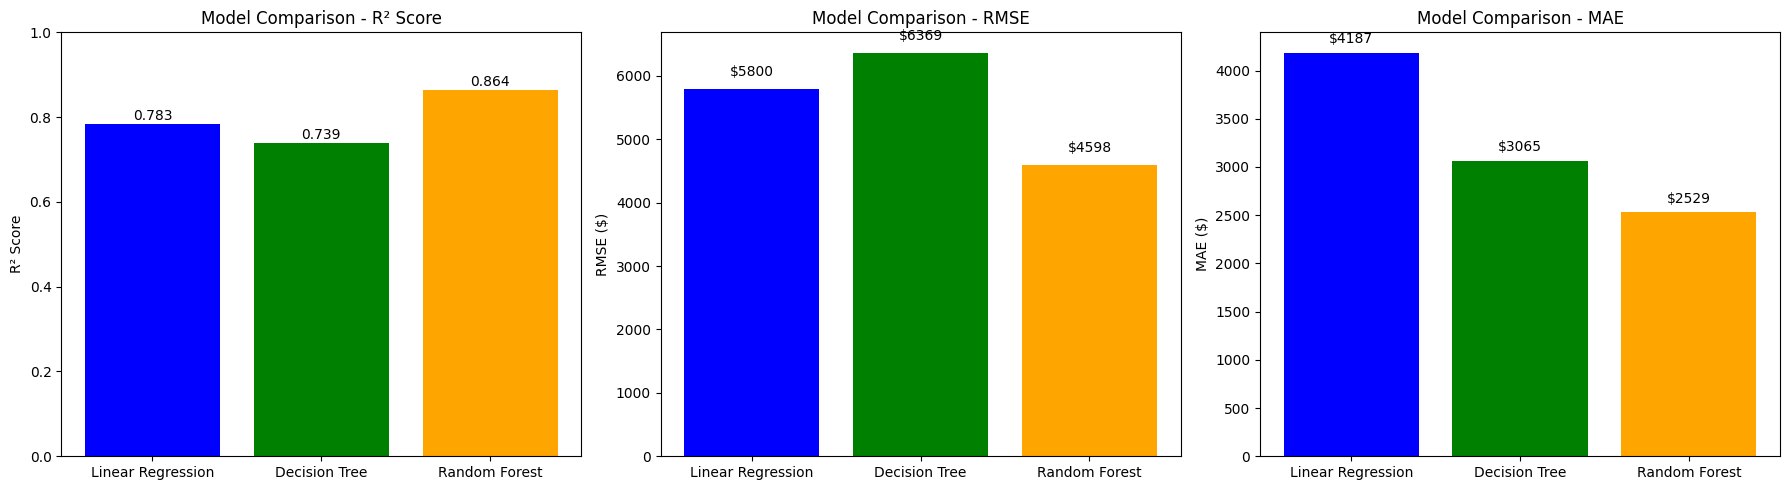


 BEST MODEL: Random Forest
   Test R²: 0.8638
   Test RMSE: $4598.02


In [11]:
# Model comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = list(results.keys())
test_r2_scores = [results[name]['test_r2'] for name in model_names]
test_rmse_scores = [results[name]['test_rmse'] for name in model_names]
test_mae_scores = [results[name]['test_mae'] for name in model_names]

# R² Score comparison
axes[0].bar(model_names, test_r2_scores, color=['blue', 'green', 'orange'])
axes[0].set_title('Model Comparison - R² Score')
axes[0].set_ylabel('R² Score')
axes[0].set_ylim(0, 1)
for i, v in enumerate(test_r2_scores):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# RMSE comparison
axes[1].bar(model_names, test_rmse_scores, color=['blue', 'green', 'orange'])
axes[1].set_title('Model Comparison - RMSE')
axes[1].set_ylabel('RMSE ($)')
for i, v in enumerate(test_rmse_scores):
    axes[1].text(i, v + 200, f'${v:.0f}', ha='center')

# MAE comparison
axes[2].bar(model_names, test_mae_scores, color=['blue', 'green', 'orange'])
axes[2].set_title('Model Comparison - MAE')
axes[2].set_ylabel('MAE ($)')
for i, v in enumerate(test_mae_scores):
    axes[2].text(i, v + 100, f'${v:.0f}', ha='center')

plt.tight_layout()
plt.show()

# Determine best model
best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
print(f"\n BEST MODEL: {best_model_name}")
print(f"   Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"   Test RMSE: ${results[best_model_name]['test_rmse']:.2f}")

## 5. Loss Curves and Training Analysis

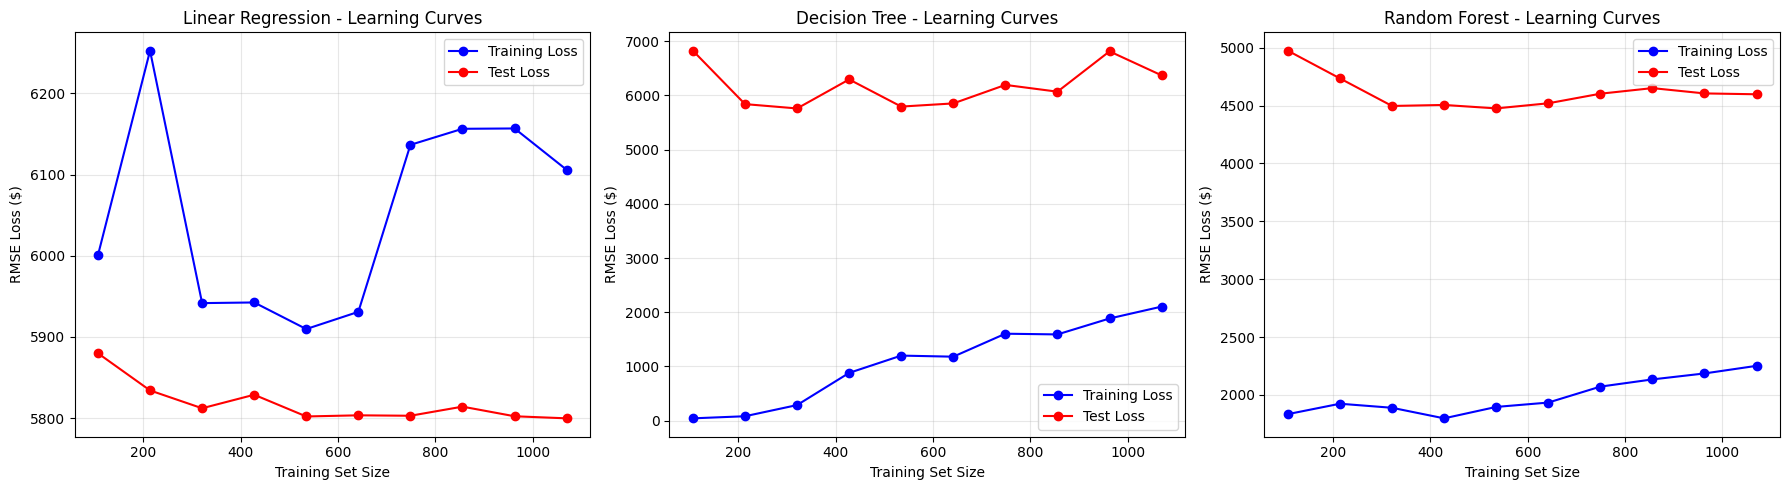

In [12]:
# Create loss curves for different training set sizes
def plot_learning_curves():
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (name, model) in enumerate(models.items()):
        train_scores = []
        test_scores = []
        
        for train_size in train_sizes:
            # Sample training data
            sample_size = int(train_size * len(X_train))
            X_sample = X_train_scaled[:sample_size] if name == 'Linear Regression' else X_train[:sample_size]
            y_sample = y_train[:sample_size]
            
            # Train model
            temp_model = type(model)(**model.get_params()) if hasattr(model, 'get_params') else type(model)()
            temp_model.fit(X_sample, y_sample)
            
            # Predict
            if name == 'Linear Regression':
                train_pred = temp_model.predict(X_sample)
                test_pred = temp_model.predict(X_test_scaled)
            else:
                train_pred = temp_model.predict(X_sample)
                test_pred = temp_model.predict(X_test)
            
            # Calculate RMSE (loss)
            train_loss = np.sqrt(mean_squared_error(y_sample, train_pred))
            test_loss = np.sqrt(mean_squared_error(y_test, test_pred))
            
            train_scores.append(train_loss)
            test_scores.append(test_loss)
        
        # Plot learning curves
        axes[idx].plot(train_sizes * len(X_train), train_scores, 'o-', label='Training Loss', color='blue')
        axes[idx].plot(train_sizes * len(X_train), test_scores, 'o-', label='Test Loss', color='red')
        axes[idx].set_title(f'{name} - Learning Curves')
        axes[idx].set_xlabel('Training Set Size')
        axes[idx].set_ylabel('RMSE Loss ($)')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_learning_curves()

## 6. Before/After Scatter Plots with Regression Line

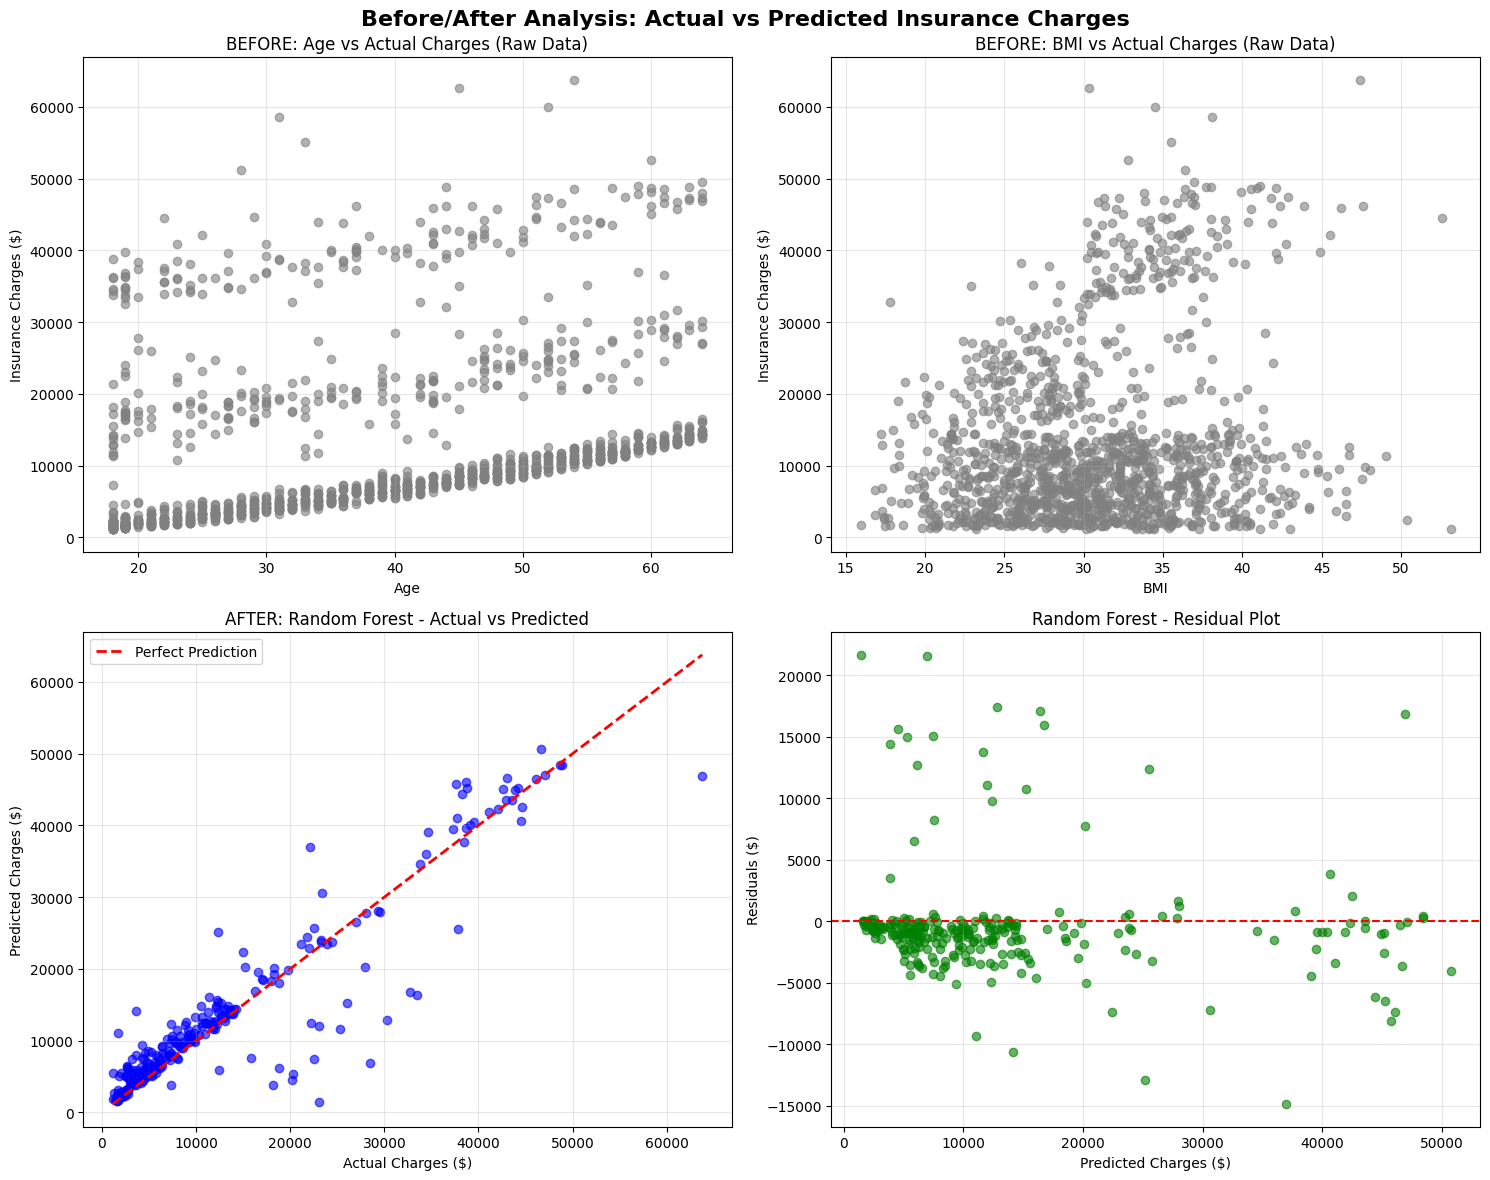


MODEL PERFORMANCE SUMMARY
Best Model: Random Forest
R² Score: 0.8638 (explains 86.4% of variance)
RMSE: $4598.02
MAE: $2528.99
Mean Actual Charges: $12968.32
Mean Predicted Charges: $13386.33


In [13]:
# Create before/after scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Before/After Analysis: Actual vs Predicted Insurance Charges', fontsize=16, fontweight='bold')

# Before: Raw data scatter plot (Age vs Charges)
axes[0,0].scatter(data['age'], data['charges'], alpha=0.6, color='gray')
axes[0,0].set_title('BEFORE: Age vs Actual Charges (Raw Data)')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Insurance Charges ($)')
axes[0,0].grid(True, alpha=0.3)

# Before: BMI vs Charges
axes[0,1].scatter(data['bmi'], data['charges'], alpha=0.6, color='gray')
axes[0,1].set_title('BEFORE: BMI vs Actual Charges (Raw Data)')
axes[0,1].set_xlabel('BMI')
axes[0,1].set_ylabel('Insurance Charges ($)')
axes[0,1].grid(True, alpha=0.3)

# After: Best model predictions
best_predictions = results[best_model_name]['predictions']

# Perfect prediction line
min_val = min(min(y_test), min(best_predictions))
max_val = max(max(y_test), max(best_predictions))

axes[1,0].scatter(y_test, best_predictions, alpha=0.6, color='blue')
axes[1,0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[1,0].set_title(f'AFTER: {best_model_name} - Actual vs Predicted')
axes[1,0].set_xlabel('Actual Charges ($)')
axes[1,0].set_ylabel('Predicted Charges ($)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - best_predictions
axes[1,1].scatter(best_predictions, residuals, alpha=0.6, color='green')
axes[1,1].axhline(y=0, color='red', linestyle='--')
axes[1,1].set_title(f'{best_model_name} - Residual Plot')
axes[1,1].set_xlabel('Predicted Charges ($)')
axes[1,1].set_ylabel('Residuals ($)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print model performance summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"R² Score: {results[best_model_name]['test_r2']:.4f} (explains {results[best_model_name]['test_r2']*100:.1f}% of variance)")
print(f"RMSE: ${results[best_model_name]['test_rmse']:.2f}")
print(f"MAE: ${results[best_model_name]['test_mae']:.2f}")
print(f"Mean Actual Charges: ${y_test.mean():.2f}")
print(f"Mean Predicted Charges: ${best_predictions.mean():.2f}")

## 7. Save the Best Model and Preprocessing Objects

In [14]:
# Save the best performing model and preprocessing objects
best_model = trained_models[best_model_name]

# Save model
joblib.dump(best_model, 'best_model.pkl')
print(f" Best model ({best_model_name}) saved as 'best_model.pkl'")

# Save encoders
joblib.dump(encoders, 'encoders.pkl')
print(" Label encoders saved as 'encoders.pkl'")
# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print(" Standard scaler saved as 'scaler.pkl'")

# Save feature columns
feature_columns = list(X.columns)
joblib.dump(feature_columns, 'feature_columns.pkl')
print(" Feature columns saved as 'feature_columns.pkl'")

print(f"\nFeature columns order: {feature_columns}")
print(f"Model type: {type(best_model).__name__}")
print(f"Uses scaled features: {'Yes' if best_model_name == 'Linear Regression' else 'No'}")

 Best model (Random Forest) saved as 'best_model.pkl'
 Label encoders saved as 'encoders.pkl'
 Standard scaler saved as 'scaler.pkl'
 Feature columns saved as 'feature_columns.pkl'

Feature columns order: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
Model type: RandomForestRegressor
Uses scaled features: No


## 8. Model Interpretation and Feature Importance

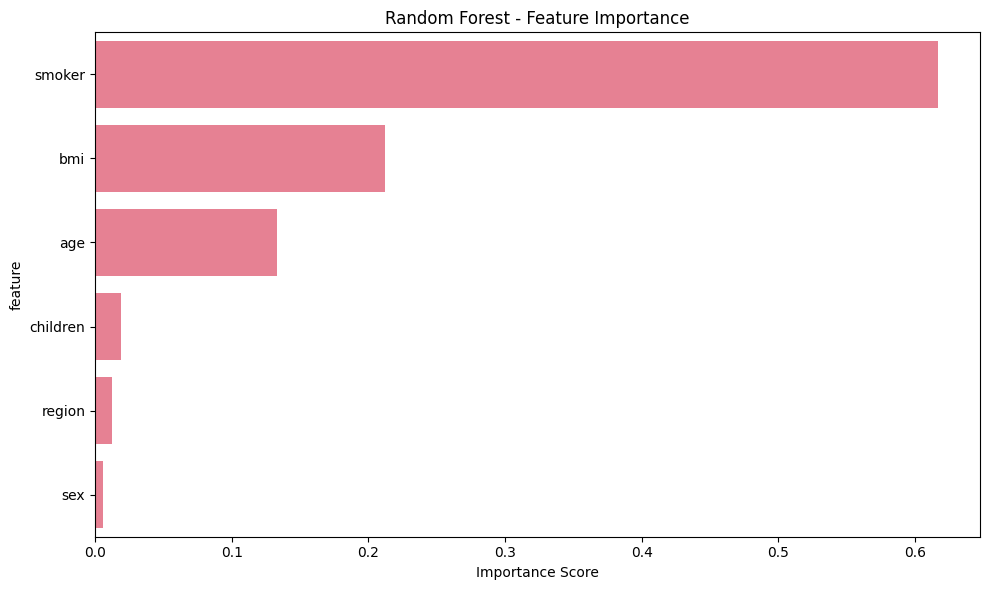


FINAL MODEL SUMMARY
 Dataset: 1,338 insurance records
 Features: 6 (age, sex, bmi, children, smoker, region)
 Best Model: Random Forest
 Performance: R² = 0.8638, RMSE = $4598.02
 Model saved and ready for deployment


In [16]:
# Feature importance analysis
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title(f'{best_model_name} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # For linear regression
    feature_coef = pd.DataFrame({
        'feature': feature_columns,
        'coefficient': best_model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    plt.figure(figsize=(10, 6))
    colors = ['red' if x < 0 else 'blue' for x in feature_coef['coefficient']]
    sns.barplot(data=feature_coef, x='coefficient', y='feature', palette=colors)
    plt.title(f'{best_model_name} - Feature Coefficients')
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.show()
    
    print("\nLinear Regression Coefficients Interpretation:")
    for _, row in feature_coef.iterrows():
        print(f"{row['feature']}: {row['coefficient']:.2f} (${abs(row['coefficient']):.2f} {'increase' if row['coefficient'] > 0 else 'decrease'} per unit)")

print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f" Dataset: 1,338 insurance records")
print(f" Features: 6 (age, sex, bmi, children, smoker, region)")
print(f" Best Model: {best_model_name}")
print(f" Performance: R² = {results[best_model_name]['test_r2']:.4f}, RMSE = ${results[best_model_name]['test_rmse']:.2f}")
print(f" Model saved and ready for deployment")